# IMD3004 - Aprendizado Profundo

### Professor: Dr. Silvan Ferreira da Silva Junior

### Aluno: João Antonio Costa Paiva Chagas

## Importações e Configurações

In [18]:
import torch
import random
import torchvision
import torch.nn as nn
import torch.optim as optim
from typing import Dict, List
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Dados

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes do CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Arquitetura simples e funções auxiliares

In [20]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleModel, self).__init__()

        # Bloco de extração de features
        self.features = nn.Sequential(
            # Bloco 1
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloco 2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Bloco classificador
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [21]:
class ConfigurableModel(nn.Module):
    def __init__(self, filters1=32, filters2=64, linear_neurons=256, num_classes=10):
        super(ConfigurableModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, filters1, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(filters1, filters2, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(filters2 * 8 * 8, linear_neurons),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(linear_neurons, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [22]:
def train_and_validate(model: nn.Module,
                       train_loader: torch.utils.data.DataLoader,
                       val_loader: torch.utils.data.DataLoader,
                       loss_function: nn.Module,
                       optimizer: torch.optim.Optimizer,
                       num_epochs: int,
                       device: torch.device) -> Dict[str, List[float]]:
    """
    Executa o ciclo de treinamento e validação para um modelo.

    Args:
        model (nn.Module): O modelo a ser treinado.
        train_loader (DataLoader): DataLoader para os dados de treino.
        val_loader (DataLoader): DataLoader para os dados de validação.
        loss_function (nn.Module): A função de perda.
        optimizer (Optimizer): O otimizador.
        num_epochs (int): O número de épocas para treinar.
        device (torch.device): O dispositivo ('cuda' ou 'cpu') para rodar o modelo.

    Returns:
        Dict[str, List[float]]: Um dicionário contendo o histórico de perdas e acurácias
                                de treino e validação.
    """
    # Dicionário para armazenar as métricas
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # --- Treinamento ---
        model.train()
        running_loss_train = 0.0
        correct_train = 0
        total_train = 0
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss_train / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_accuracy)

        # --- Validação ---
        model.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                running_loss_val += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss_val / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}] -> '
              f'Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.2f}% | '
              f'Val Loss: {val_loss:.3f}, Val Acc: {val_accuracy:.2f}%')

    return history

In [23]:
def plot_history(history: Dict[str, List[float]]):
    """
    Plota os gráficos de perda e acurácia de treinamento e validação.

    Args:
        history (Dict[str, List[float]]): Dicionário com o histórico de métricas.
                                          Deve conter as chaves: 'train_loss', 'val_loss',
                                          'train_acc', 'val_acc'.
    """
    train_losses = history['train_loss']
    val_losses = history['val_loss']
    train_accuracies = history['train_acc']
    val_accuracies = history['val_acc']

    num_epochs = len(train_losses)
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Gráfico de Perda (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Gráfico de Acurácia (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [24]:
def run_hyperparameter_search(model_class,
                              configurations,
                              train_loader,
                              val_loader,
                              num_epochs,
                              device,
                              lr=0.001):
    """
    Executa uma busca de hiperparâmetros para uma lista de configurações.

    Args:
        model_class: A classe do modelo a ser instanciada (ex: ConfigurableCNN).
        configurations (List[Dict]): Uma lista de dicionários, onde cada dicionário
                                     representa uma configuração de hiperparâmetros.
        ... (outros args são os mesmos de train_and_validate) ...

    Returns:
        Tuple[Dict, float]: A melhor configuração e a melhor acurácia de validação.
    """
    best_val_acc = 0.0
    best_config = None
    best_history = None

    for i, config in enumerate(configurations):
        print(f"\n--- Teste [{i+1}/{len(configurations)}] ---")
        print(f"Configuração: {config}")

        model = model_class(**config).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_function = nn.CrossEntropyLoss()

        history = train_and_validate(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device)

        max_acc_in_run = max(history['val_acc'])
        if max_acc_in_run > best_val_acc:
            best_val_acc = max_acc_in_run
            best_config = config
            best_history = history

    if best_config:
        print(f"Melhor configuração encontrada: {best_config}")
        print(f"Melhor acurácia de validação: {best_val_acc:.2f}%")
        plot_history(best_history)
    else:
        print("Nenhum resultado válido encontrado.")

    return best_config, best_val_acc

## Exercícios

### Exercício 1

O modelo está muito simples para o problema. Aumente o número de canais nas camadas convolucionais. Além disso, adicione Batch Normalization após as camadas convolucionais e Dropout após as camadas lineares no modelo. Compare com a implementação original.

Epoch [1/10] -> Train Loss: 1.425, Train Acc: 49.00% | Val Loss: 1.183, Val Acc: 57.53%
Epoch [2/10] -> Train Loss: 1.092, Train Acc: 61.26% | Val Loss: 1.055, Val Acc: 62.16%
Epoch [3/10] -> Train Loss: 0.943, Train Acc: 66.98% | Val Loss: 0.991, Val Acc: 64.93%
Epoch [4/10] -> Train Loss: 0.844, Train Acc: 70.41% | Val Loss: 0.908, Val Acc: 68.31%
Epoch [5/10] -> Train Loss: 0.756, Train Acc: 73.57% | Val Loss: 0.932, Val Acc: 67.56%
Epoch [6/10] -> Train Loss: 0.683, Train Acc: 76.07% | Val Loss: 0.909, Val Acc: 68.92%
Epoch [7/10] -> Train Loss: 0.611, Train Acc: 78.62% | Val Loss: 0.908, Val Acc: 69.77%
Epoch [8/10] -> Train Loss: 0.545, Train Acc: 80.89% | Val Loss: 0.921, Val Acc: 70.32%
Epoch [9/10] -> Train Loss: 0.487, Train Acc: 82.85% | Val Loss: 0.989, Val Acc: 69.07%
Epoch [10/10] -> Train Loss: 0.428, Train Acc: 84.99% | Val Loss: 1.017, Val Acc: 69.36%
Epoch [1/10] -> Train Loss: 1.510, Train Acc: 45.06% | Val Loss: 1.173, Val Acc: 59.41%
Epoch [2/10] -> Train Loss: 1.2

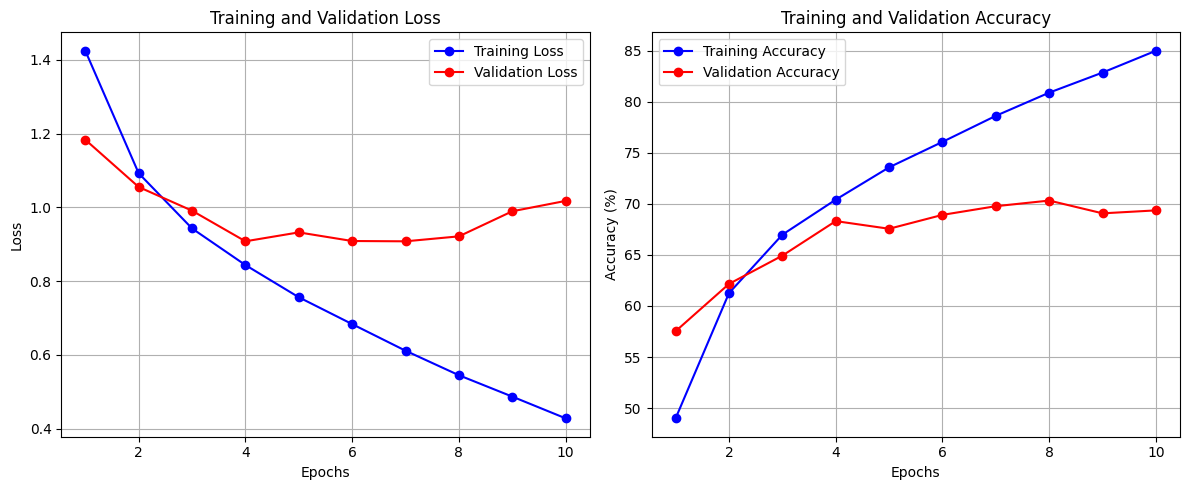

Histórico do modelo mais complexo


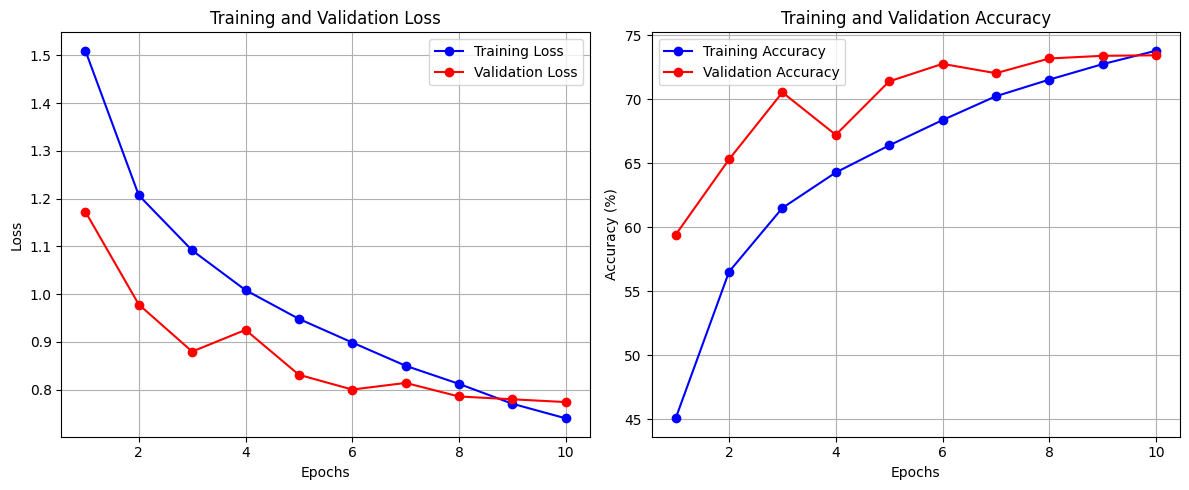

In [25]:
loss_function = nn.CrossEntropyLoss()                                           # Função de perda

simple_model = SimpleModel().to(device)                                         # Modelo simples
simple_model_optimizer = optim.Adam(simple_model.parameters(), lr=0.001)        # Otimizador do modelo simples
simple_model_history = train_and_validate(simple_model, train_loader, test_loader, loss_function, simple_model_optimizer, 10, device) # Treina e valida,
                                                                                                                                      # recebe um histórico de contendo as perdas e
                                                                                                                                      # acurácias de treino e validação


complex_model = ConfigurableModel().to(device)                                  # Modelo mais complexo, instanciado sem argumentos, usa os defaults (32, 64, 256)
complex_model_optimizer = optim.Adam(complex_model.parameters(), lr=0.001)      # Otimizador do modelo complexo
complex_model_history = train_and_validate(complex_model, train_loader, test_loader, loss_function, complex_model_optimizer, 10, device)

print("Histórico do modelo simples")
plot_history(simple_model_history)                                              # Plota o histórico de treino e validação do modelo simples

print("Histórico do modelo mais complexo")
plot_history(complex_model_history)                                             # Plota o histórico de treino e validação do modelo mais complexo

### Exercício 2

Experimente diferentes combinações para o número de filtros nas duas camadas convolucionais. Avalie todas as combinações possíveis e identifique o modelo que obtiver o melhor desempenho no conjunto de validação.


--- Teste [1/4] ---
Configuração: {'filters1': 16, 'filters2': 32, 'linear_neurons': 256}
Epoch [1/10] -> Train Loss: 1.468, Train Acc: 46.78% | Val Loss: 1.137, Val Acc: 59.24%
Epoch [2/10] -> Train Loss: 1.202, Train Acc: 57.33% | Val Loss: 1.058, Val Acc: 63.29%
Epoch [3/10] -> Train Loss: 1.090, Train Acc: 61.45% | Val Loss: 1.003, Val Acc: 64.73%
Epoch [4/10] -> Train Loss: 1.013, Train Acc: 64.38% | Val Loss: 0.908, Val Acc: 68.24%
Epoch [5/10] -> Train Loss: 0.956, Train Acc: 66.47% | Val Loss: 0.921, Val Acc: 67.76%
Epoch [6/10] -> Train Loss: 0.912, Train Acc: 67.88% | Val Loss: 0.850, Val Acc: 70.28%
Epoch [7/10] -> Train Loss: 0.867, Train Acc: 69.67% | Val Loss: 0.851, Val Acc: 70.15%
Epoch [8/10] -> Train Loss: 0.834, Train Acc: 70.72% | Val Loss: 0.839, Val Acc: 70.95%
Epoch [9/10] -> Train Loss: 0.801, Train Acc: 71.79% | Val Loss: 0.811, Val Acc: 71.57%
Epoch [10/10] -> Train Loss: 0.773, Train Acc: 72.81% | Val Loss: 0.844, Val Acc: 71.15%

--- Teste [2/4] ---
Configu

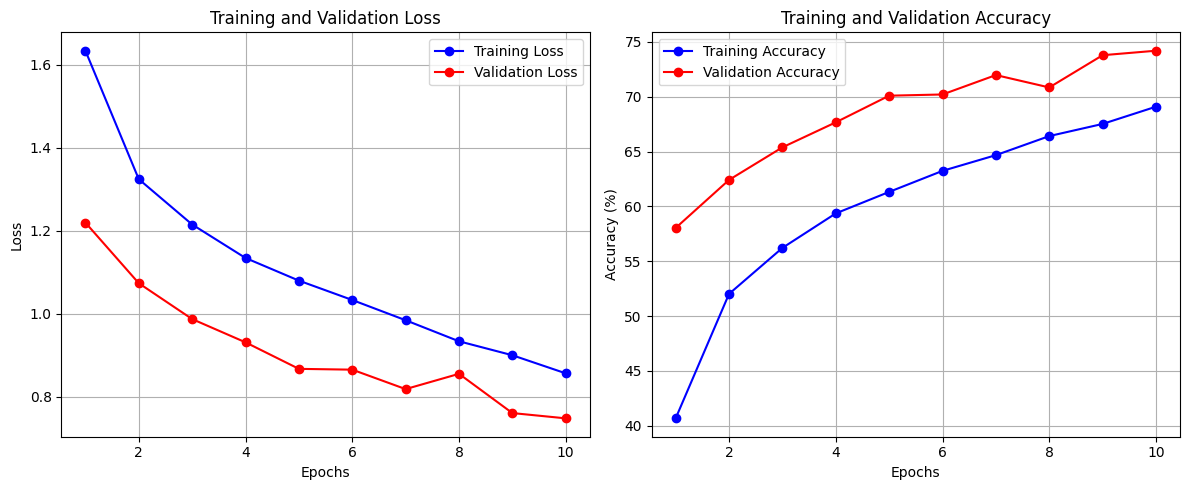

In [26]:
grid_search_configs = [                                                         # Configurações de filtros
    {'filters1': 16, 'filters2': 32, 'linear_neurons': 256},
    {'filters1': 32, 'filters2': 64, 'linear_neurons': 256},
    {'filters1': 64, 'filters2': 128, 'linear_neurons': 256},
    {'filters1': 32, 'filters2': 32, 'linear_neurons': 256},
]

best_config_ex2, best_val_acc_ex2 = run_hyperparameter_search(                  # Determina a melhor configuração (dentre as fornecidas) e a melhor acurácia
    model_class=ConfigurableModel,
    configurations=grid_search_configs,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=10,
    device=device,
    lr=0.001
)

### Exercício 3

Explore diferentes configurações escolhidas aleatoriamente para o número de filtros nas camadas convolucionais e dos neurônios nas camadas lineares. Treine e avalie N configurações, registrando o desempenho em validação. Identifique o modelo com os melhores resultados entre as amostras testadas.


--- Teste [1/10] ---
Configuração: {'filters1': 48, 'filters2': 64, 'linear_neurons': 512}
Epoch [1/10] -> Train Loss: 1.463, Train Acc: 47.06% | Val Loss: 1.097, Val Acc: 60.28%
Epoch [2/10] -> Train Loss: 1.148, Train Acc: 59.16% | Val Loss: 0.973, Val Acc: 65.34%
Epoch [3/10] -> Train Loss: 1.019, Train Acc: 63.91% | Val Loss: 0.873, Val Acc: 70.09%
Epoch [4/10] -> Train Loss: 0.940, Train Acc: 66.95% | Val Loss: 0.844, Val Acc: 70.55%
Epoch [5/10] -> Train Loss: 0.872, Train Acc: 69.21% | Val Loss: 0.825, Val Acc: 71.69%
Epoch [6/10] -> Train Loss: 0.817, Train Acc: 71.21% | Val Loss: 0.759, Val Acc: 73.89%
Epoch [7/10] -> Train Loss: 0.764, Train Acc: 73.24% | Val Loss: 0.733, Val Acc: 74.48%
Epoch [8/10] -> Train Loss: 0.720, Train Acc: 74.90% | Val Loss: 0.756, Val Acc: 73.89%
Epoch [9/10] -> Train Loss: 0.670, Train Acc: 76.32% | Val Loss: 0.741, Val Acc: 74.71%
Epoch [10/10] -> Train Loss: 0.631, Train Acc: 77.79% | Val Loss: 0.781, Val Acc: 73.33%

--- Teste [2/10] ---
Confi

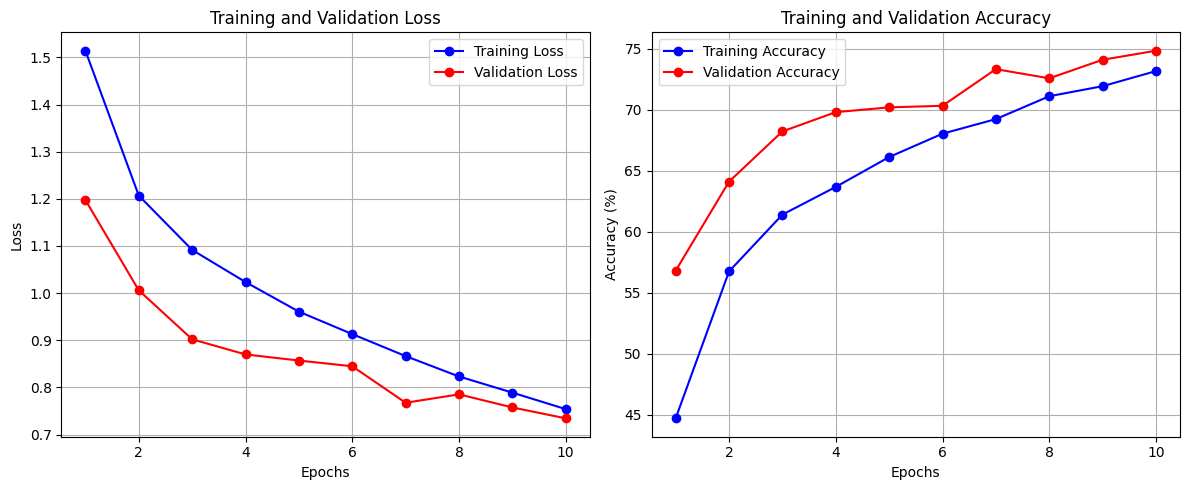

In [27]:
filters1_options = [16, 32, 48, 64]                                             # Possíveis números de filtros
filters2_options = [32, 64, 96, 128]                                            # Possíveis números de filtros
linear_neurons_options = [128, 256, 512]                                        # Possíveis números de neurônios nas camadas lineares
N_configs = 10                                                                  # Número de configurações

random_search_configs = []                                                      # Lista para armazenar as configurações aleatórias
for _ in range(N_configs):                                                      # Laço para popular a lista
    f1 = random.choice(filters1_options)                                        # Escolhe um número de filtros aleatório
    f2 = random.choice(filters2_options)                                        # Escolhe um número de filtros aleatório

    while f2 < f1:                                                              # f2 tem que ser maior que f1
        f2 = random.choice(filters2_options)                                    # Escolhe um novo valor para f2

    ln = random.choice(linear_neurons_options)                                  # Escolhe um número de neurônios aleatório
    random_search_configs.append({'filters1': f1, 'filters2': f2, 'linear_neurons': ln}) # Popula a lista

best_config_ex3, best_val_acc_ex3 = run_hyperparameter_search(                  # Determina a melhor configuração (dentre as fornecidas) e a melhor acurácia
    model_class=ConfigurableModel,
    configurations=random_search_configs,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=10,
    device=device,
    lr=0.001
)